This was working, then i reset the runtime and now getting a broadcasting error. 

In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os, numpy as np, scipy as sp, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, pymc3 as pm, arviz as az
plt.style.use("seaborn-darkgrid")
np.seterr(divide='ignore')

tune  = 100   # number of tuning steps before we start keeping good data
cores = 4     # kaggle kernels have 4 cores, so we can use each one to run chains in parallel
eps   = 0.2   # we want prior distributions centered near, but not right at, the true value.  eps pushes the prior away from true
seed  = 42
refresh = False  
# refresh = True  # Delete & recreate any existing data
draws = 4 * tune
draws_total = draws * cores

In [3]:
# initial conditions - p.126
times = np.arange(0, 22)
classes_HIV = ['S','I1','I2','I3','I4']
classes_SIR = ['S','I']
y0_HIV = [6992.7, 7.3 , 0, 0,0]
y0_SIR = [6992.7, 7.3]
N = np.sum(y0_HIV)


# published parameter point estimates - p.129
theta = {'alpha': 235.567,'beta': 0.332276 , 'gamma': 0.349035}
n_theta = len(theta)
#obs_SIR = [7.3,9.2,11.3,13.5,15.9,18.3,20.6,22.7,24.6,26.3,27.8,29.0,
#          30.0,30.8,31.4,31.9,32.4,32.8,33.4,33.3,34.0,34.0] 

# normalize parameters - beta must be multiplied by N, all others unchanged
theta_n = theta.copy()
#theta_n['beta'] *= N
theta_n['sigma'] = 1.0

theta_loc = {key: val * np.random.default_rng(seed).uniform(1-eps, 1+eps) for key,val in theta_n.items()}

# ODE model - p.126
def ODE_HIV(y, t, p): 
    Lambda = 100
    mu = 1/70
    i_s = y[1]+y[2]+y[3]+y[4]
    n_s = y[0]+y[1]+y[2]+y[3]+y[4] 
    lamb = p[1]*np.exp(-p[0]*i_s /n_s) * i_s / n_s
    
    ds = Lambda - lamb * y[0] - mu *    y[0]
    di1 = lamb * y[0] - (p[2] + mu)* y[1]
    di2 = p[2] * y[1] - (p[2] + mu)* y[2]
    di3 = p[2] * y[2] - (p[2] + mu)* y[3]
    di4 = p[2] * y[3] - (p[2] + mu)* y[4]
    return [ds, di1, di2, di3, di4]

def ODE_SIR(y, t, p):
    Lambda = 100
    mu = 1/70
    n_s = y[0]+y[1]
    lamb = p[1]*np.exp(-p[0]*y[1] /n_s) * y[1] / n_s  
    ds = Lambda - lamb * y[0] - mu * y[0]
    di = lamb * y[0] - mu * y[1] 
    return [ds, di]

# y_SIR, y_HIV, obs_SIR, obs_HIV, z_SIR, and z_HIV. Each _SIR has 2 classes 
#(one $S$ & one $I$) and each _HIV has 5 classes (one $S$ & four $I_j$).
# I have 2 functions to convert between these variables.

def HIV_to_SIR(hiv): 
    return np.vstack([hiv[0],np.sum(hiv[1:])])

def SIR_to_HIV(sir): #########
    I = y_HIV[1:]
    T = np.sum(I,axis=0)
    K = I/T
    print(K.shape,sir[1].shape)
    return np.vstack([sir[0], sir[1]*K])

def inject_noise(noise, seed, obs):
    """Add noise to S class predictions from odeint"""
    z = obs.copy()
    z[0] = np.random.default_rng(seed).lognormal(mean=np.log(z[0]), sigma=noise)
    return z

def plot_data(z,y, classes):
    colors = ['red', 'green', 'orange', 'blue', 'yellow', 'violet']
    d = {'marker':'+', 'markersize':5, 'linestyle':''}
    for i in range(0, 2):
        clr = colors.pop(0)
        plt.plot(times, y[i], c=clr, label=classes[i])
        plt.plot(times, z[i], c=clr, label=None, **d)
    plt.legend()
    plt.show()
    
y_SIR = sp.integrate.odeint(ODE_SIR, y0_SIR, times, (list(theta.values()),), rtol=1e-8)
y_HIV = sp.integrate.odeint(ODE_HIV, y0_HIV, times, (list(theta.values()),), rtol=1e-8)
y_SIR = y_SIR.T/N
y_HIV = y_HIV.T/N

 # get ODE predictions
 # normalize & transpose


# incorporate observations in Table 6.1 p.126
obs_SIR = y_SIR.copy()
obs_SIR[1,0:] = np.array([7.3,9.3,11.3,13.5,15.9,18.3,20.6,22.7,24.6,26.3,27.8,29.0,30.0,30.8,31.4,31.9,32.4,32.8,33.4,33.3,34.0,34.0]) / N
obs_HIV = SIR_to_HIV(obs_SIR)

(4, 22) (22,)


In [4]:
# normalize parameters - beta must be multiplied by N, all others unchanged
theta_n = theta.copy()
#theta_n['beta'] *= N
theta_n['sigma'] = 1.0

# guess loc for priors, but inject some error so Bayes doesn't get to start at the correct answer
theta_loc = {key: val * np.random.default_rng(seed).uniform(1-eps, 1+eps) for key,val in theta_n.items()}

# create pymc3 ODE object
ODE_pymc3_HIV = pm.ode.DifferentialEquation(
    func=ODE_HIV,
    times=times[1:],
    t0=times[0],
    n_states=len(classes_HIV),
    n_theta=n_theta)

ODE_pymc3_SIR = pm.ode.DifferentialEquation(
    func=ODE_SIR,
    times=times[1:],
    t0=times[0],
    n_states=len(classes_SIR),
    n_theta=n_theta)


def make_model_HIV(z, classes):
    """Creates the pymc3 model object, but does not run it"""
    with pm.Model() as model:
        # Choose priors on alpha, beta, and sigma
        sigma_prior = pm.HalfCauchy("sigma", theta_loc['sigma'], shape=len(classes))
        params = theta_loc.copy()
        params.pop('sigma')
        theta_prior = [pm.Lognormal(key, mu=pm.math.log(loc), sigma=1.0) for key,loc in params.items()]
        curves = ODE_pymc3_HIV(y0=z.T[0], theta=theta_prior)
        Z = pm.Lognormal("Z", mu=pm.math.log(curves), sigma=sigma_prior, observed=z.T[1:])
    return model

def make_model_SIR(z, classes):
    """Creates the pymc3 model object, but does not run it"""
    with pm.Model() as model:
        # Choose priors on alpha, beta, and sigma
        sigma_prior = pm.HalfCauchy("sigma", theta_loc['sigma'], shape=len(classes))
        params = theta_loc.copy()
        params.pop('sigma')
        theta_prior = [pm.Lognormal(key, mu=pm.math.log(loc), sigma=1.0) for key,loc in params.items()]
        curves = ODE_pymc3_SIR(y0=z.T[0], theta=theta_prior)
        Z = pm.Lognormal("Z", mu=pm.math.log(curves), sigma=sigma_prior, observed=z.T[1:])
    return model

def analyze(idata,y,z, classes):
    """Analyzes results of pymc3 run"""
    # Compute stats on parameters posterior distributions
    theta_stats = idata.posterior.to_dataframe().describe().T  # 7-number summaries
    theta_stats['draws'] = idata.posterior.beta.size  # count
    theta_stats['TRUE'] = pd.Series(theta_n)          # true value from p.126
    theta_stats['prior_loc'] = pd.Series(theta_loc)   # start value for bayes
    theta_stats = theta_stats[['draws', 'min', '25%', '50%', 'TRUE', 'mean', '75%', 'max', 'prior_loc']]  # rearrange columns
    display(theta_stats)
    az.plot_posterior(idata, round_to=4, hdi_prob=0.95)  # plot posteriors
    plt.show()
    
    # plot posterior predictive data (aka - draw parameters from their posterior and run ODE with them)
    pred = idata.posterior_predictive.to_dataframe().reset_index().rename(columns={'Z_dim_0':'time', 'Z_dim_1':'class'})
    pred['time'] += times[1]  # replace time=0 with time=first observations
    pred = pred.pivot(['chain','draw','class'], 'time', 'Z')  # convert from "long form" to "wide form" with column for each time
    t0 = times[0]
    pred[t0] = 0.0  # create placeholder column for initial condition, to be filled in later
    pred = pred[sorted(pred.columns)]  # sort columns in order
    r = len(classes)
    fig, axes = plt.subplots(r, 2, figsize=(12, 4*r))  # create grid of plots
    i = -1  # current row of plot grid
    for c, df in pred.groupby('class'):  # make plot for each class
        i += 1
        data = df.reset_index(drop=True)
        data[t0] = y[c,0]  # fill initial condition columns created above
        for j in range(2):  # create boxplot and lineplot side-by-side
            ax = axes[i,j]
            if j == 0:
                # dt is a silly hack to make boxplot overlay correctly with ODE solution & observed data
                dt = t0
                sns.boxplot(data=data, showfliers=False, ax=ax)  # posterior predictive as boxplots
                # find good lower and upper ylim
                l = max(ax.get_ylim()[0], 0.0)
                u = min(ax.get_ylim()[1], 1.1)
            elif j == 1:
                # lineplot does not need the same silly hack
                dt = 0
                # lineplot takes a long time, so we limit the number of posterior predictions to show
                num_plots = 300
                sns.lineplot(data=data.sample(num_plots).T, linewidth=0.5, alpha=0.9, legend=False, ax=ax)  # posterior predictive data as lines
            ax.plot(times-dt, y[c], color='red' , linewidth=3)  # plot ODE solution
            ax.plot(times-dt, z[c], color='blue', marker='+', markersize=5, linestyle='')  # plot observed data
            ax.set_xticks(times-dt)
            ax.tick_params('x', labelrotation=90)
            ax.set_xlabel('time')
            ax.xaxis.grid(False)
            ax.yaxis.grid(True)
            ax.set_ylabel(classes[c])
            ax.set_ylim(l, u)  # use l, u range from boxplot
    plt.tight_layout()
    plt.show()
    return theta_stats

def del_file(file):
    """ delete file if it exists"""
    try:
        os.remove(file)
    except OSError:
        pass



For noise=0.02 draws_total=1600 ... 

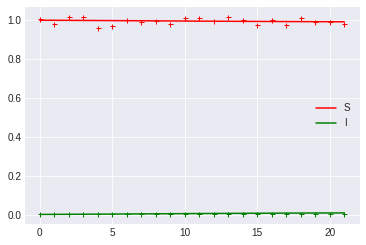

Sampling posterior


Sampling posterior_predictive


,draws,min,25%,50%,TRUE,mean,75%,max,prior_loc
sigma,1600,0.215441,0.349878,2.434928,1.000000,3.601441,6.707569,14.192130,1.109582
alpha,1600,6.664311,133.917650,271.266978,235.567000,446.345150,495.734176,11025.689661,261.381002
beta,1600,0.090168,0.107054,0.111133,0.332276,0.111249,0.115504,0.134880,0.368688
gamma,1600,0.017077,0.199844,0.378707,0.349035,0.615353,0.760772,6.811536,0.387283


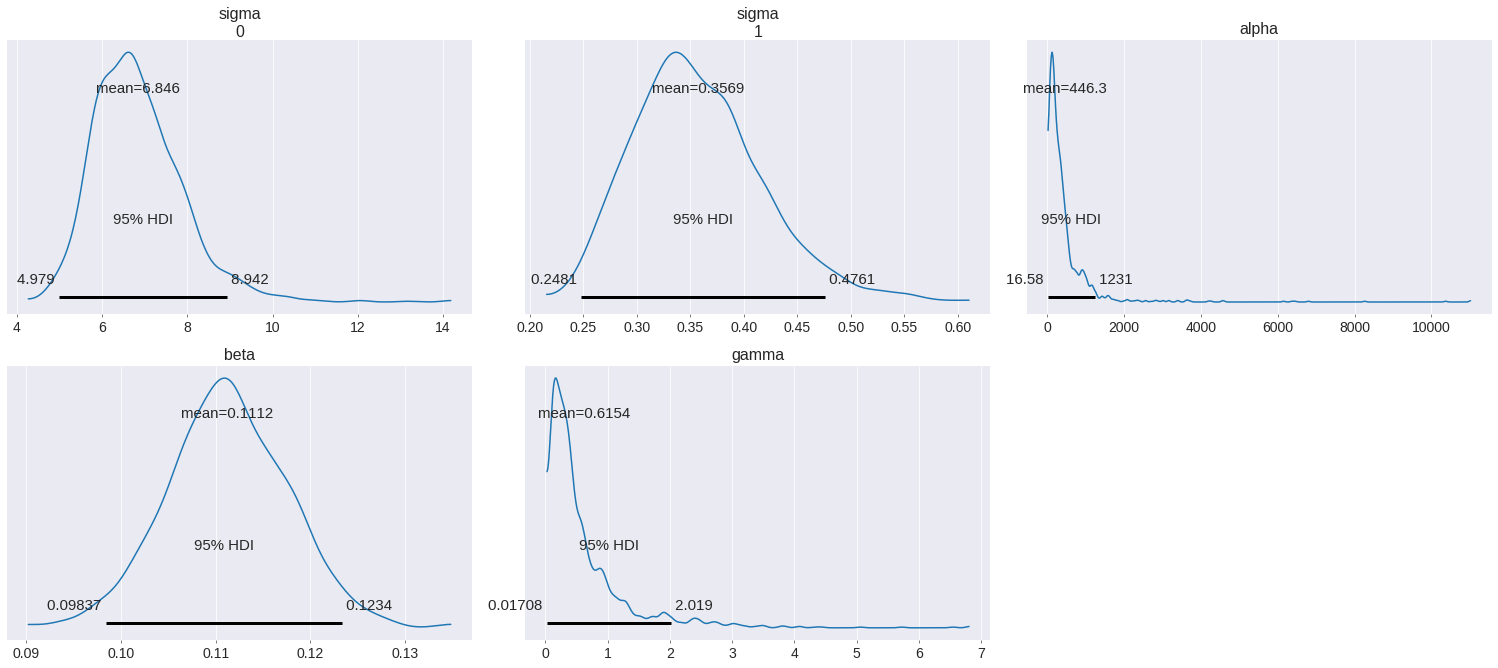

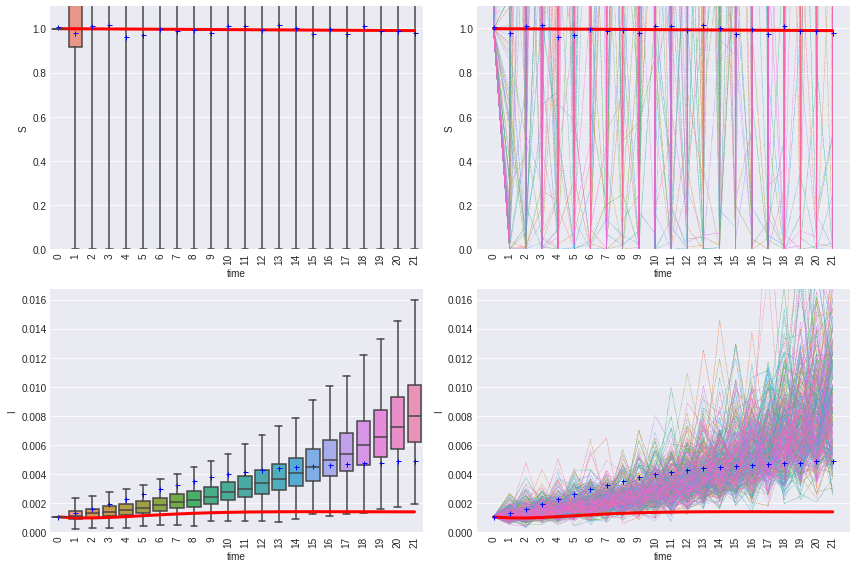

In [4]:
# noises = [0.01, 0.02, 0.05, 0.1]
noises = [0.02]
for noise in sorted(noises): # amount of noise to inject into ode-solved values & day to start observed data    
    print(f'\n\nFor noise={noise} draws_total={draws_total}', end=' ... ')
    file = f'bayes_noise={int(noise*100)%100}_draws={draws_total}.netcdf'  # file to read & write data
    z_SIR = inject_noise(noise, seed, obs_SIR)
    plot_data(z_SIR,y_SIR ,classes_SIR)
    model1 = make_model_SIR(z_SIR, classes_SIR)
    with model1:
        try:
            assert not refresh  # if refresh true, go to except block and re-create
            idata = az.from_netcdf(file)  # try to read existing data, if fail, go to except block and re-create
            print(f'using idata from {file}')
        except:
            # The big, intense line is below.  It runs MCMC and can take a long time
            # tune = # steps to throw away at the beginning (bad data)
            # draws = # steps to keep
            # cores = # cores in machine - use them all
            # chains = cores to use all available power
            print('Sampling posterior')
            idata = pm.sample(tune=tune, draws=draws, cores=cores, chains=cores, target_accept=0.9, return_inferencedata=True)
            # save to file for reuse
            del_file(file)
            idata.to_netcdf(file)
        # Now we have the distribution for parameters.  We'd like to see what that means for S & I evolutions
        # pymc3 calls this "sample posterior predictive"
        # If we're using existing data, it may have posterior_predictive already.  Else, generate
        if not hasattr(idata, 'posterior_predictive'):
            # Draw samples
            print('Sampling posterior_predictive')
            ppc = pm.sample_posterior_predictive(idata, keep_size=True)
            # put into idata
            az.concat(idata, az.from_dict(posterior_predictive=ppc), inplace=True)
            # delete old file and save new one
            del_file(file)
            idata.to_netcdf(file)
        analyze(idata,y_HIV, z_SIR, classes_SIR)



For noise=0.2 draws_total=1600 ... 

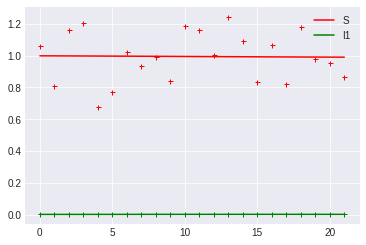

Sampling posterior


Sampling posterior_predictive


,draws,min,25%,50%,TRUE,mean,75%,max,prior_loc
sigma,1600,0.094849,0.192926,0.268562,1.000000,1.575554,0.402012,12.344450,1.109582
alpha,1600,11.624590,114.203546,212.159915,235.567000,299.891250,369.863602,2453.342177,261.381002
beta,1600,0.151977,0.159259,0.161228,0.332276,0.161161,0.162926,0.170879,0.368688
gamma,1600,0.348159,0.375568,0.382886,0.349035,0.383182,0.390196,0.427965,0.387283


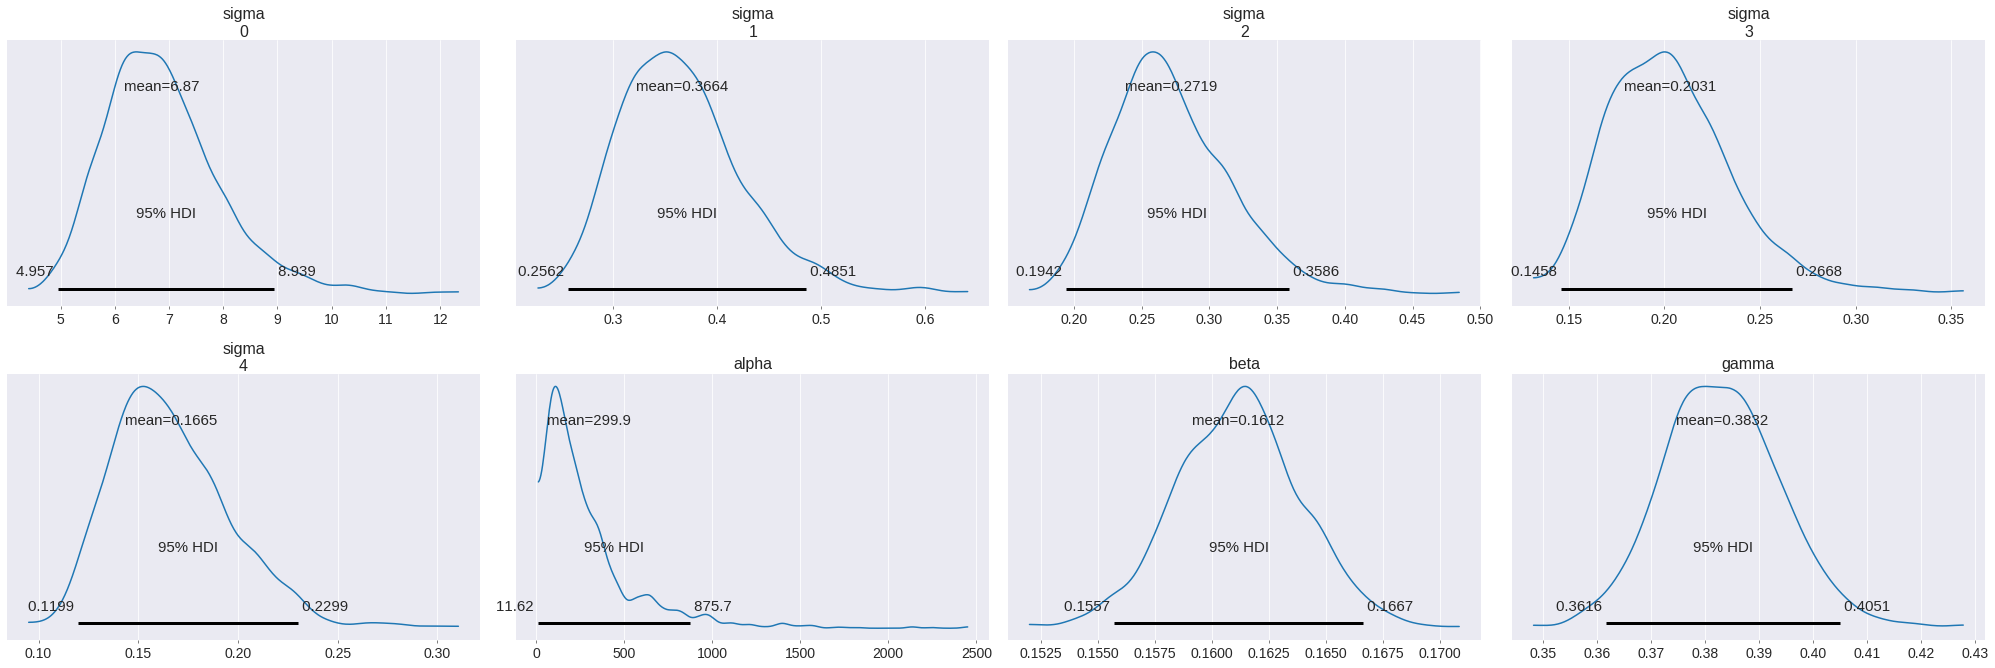

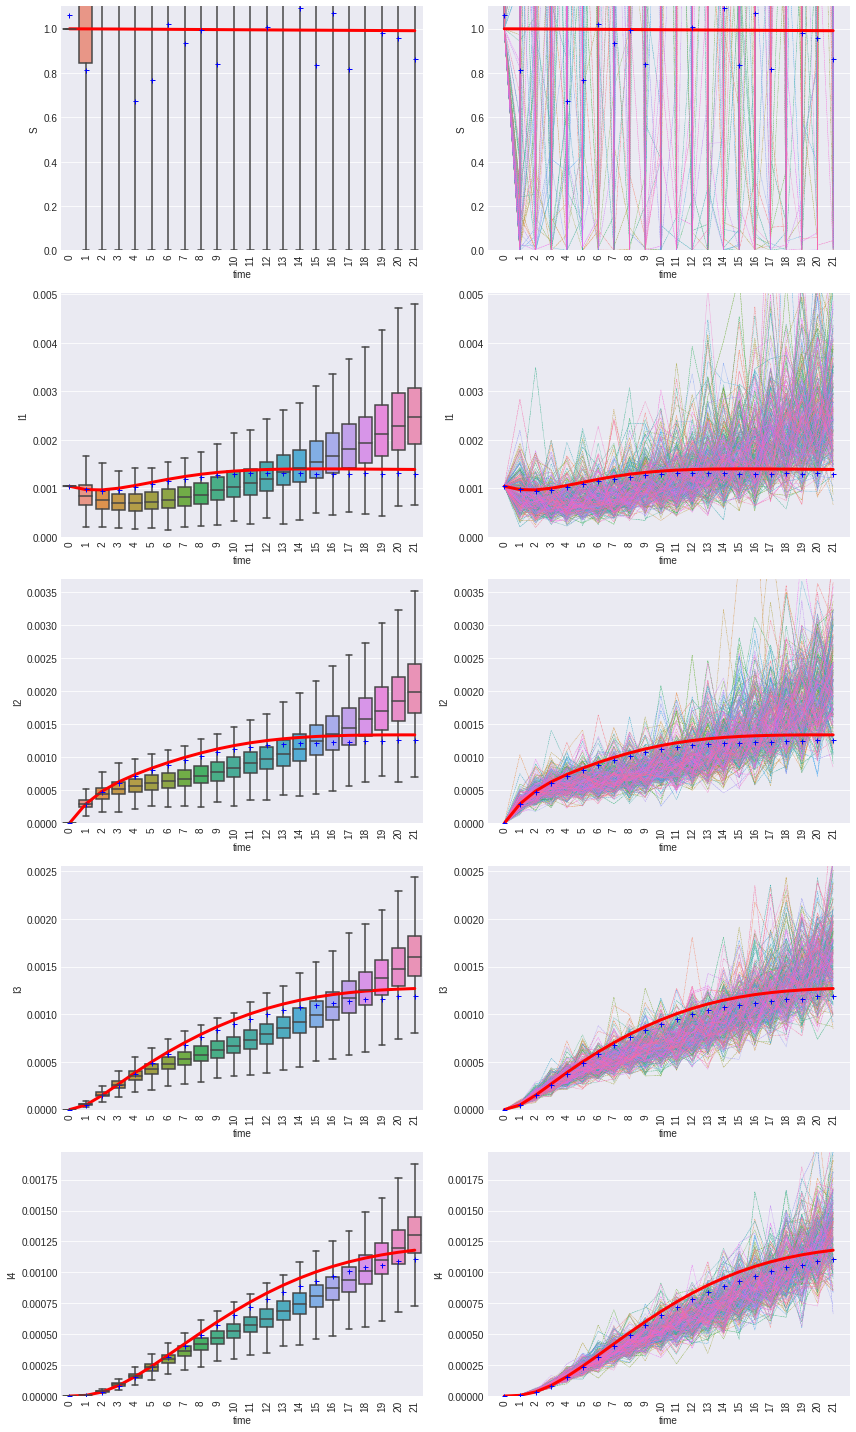

In [6]:
noises = [.2]
for noise in sorted(noises): # amount of noise to inject into ode-solved values & day to start observed data    
    print(f'\n\nFor noise={noise} draws_total={draws_total}', end=' ... ')
    file = f'bayes_noise={int(noise*100)%100}_draws={draws_total}.netcdf'  # file to read & write data
    z_HIV = inject_noise(noise, seed, obs_HIV)
    plot_data(z_HIV,y_HIV ,classes_HIV)
    model2 = make_model_HIV(z_HIV, classes_HIV)
    with model2:
        try:
            assert not refresh  # if refresh true, go to except block and re-create
            idata = az.from_netcdf(file)  # try to read existing data, if fail, go to except block and re-create
            print(f'using idata from {file}')
        except:
            # The big, intense line is below.  It runs MCMC and can take a long time
            # tune = # steps to throw away at the beginning (bad data)
            # draws = # steps to keep
            # cores = # cores in machine - use them all
            # chains = cores to use all available power
            print('Sampling posterior')
            idata = pm.sample(tune=tune, draws=draws, cores=cores, chains=cores, target_accept=0.9, return_inferencedata=True)
            # save to file for reuse
            del_file(file)
            idata.to_netcdf(file)
        # Now we have the distribution for parameters.  We'd like to see what that means for S & I evolutions
        # pymc3 calls this "sample posterior predictive"
        # If we're using existing data, it may have posterior_predictive already.  Else, generate
        if not hasattr(idata, 'posterior_predictive'):
            # Draw samples
            print('Sampling posterior_predictive')
            ppc = pm.sample_posterior_predictive(idata, keep_size=True)
            # put into idata
            az.concat(idata, az.from_dict(posterior_predictive=ppc), inplace=True)
            # delete old file and save new one
            del_file(file)
            idata.to_netcdf(file)
        analyze(idata,y_HIV, z_HIV, classes_HIV)

In [ ]:
import os, numpy as np, scipy as sp, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, pymc3 as pm, arviz as az
plt.style.use("seaborn-darkgrid")
np.seterr(divide='ignore')

tune  = 500   # number of tuning steps before we start keeping good data
cores = 4     # kaggle kernels have 4 cores, so we can use each one to run chains in parallel
eps   = 0.2   # we want prior distributions centered near, but not right at, the true value.  eps pushes the prior away from true
seed  = 42
refresh = False  
# refresh = True  # Delete & recreate any existing data
draws = 4 * tune
draws_total = draws * cores

# initial conditions - p.126
times = np.arange(1, 15)
classes = ['S','I']
y0 = [760, 3]
N = np.sum(y0)

# published parameter point estimates - p.129
theta = {'beta' : 0.00237, 'alpha': 0.465}
n_theta = len(theta)

# ODE model - p.126
def ODE(y, t, p):
    ds = -p[0] * y[0] * y[1]
    di =  p[0] * y[0] * y[1] - p[1] * y[1]
    return [ds, di]

def inject_noise(noise, seed):
    """Add noise to S class predictions from odeint"""
    z = obs.copy()
    z[0] = np.random.default_rng(seed).lognormal(mean=np.log(z[0]), sigma=noise)
    return z

def plot_data(z):
    colors = ['red', 'green', 'orange', 'blue', 'yellow', 'violet']
    d = {'marker':'+', 'markersize':5, 'linestyle':''}
    for i in range(0, 2):
        clr = colors.pop(0)
        plt.plot(times, y[i], c=clr, label=classes[i])
        plt.plot(times, z[i], c=clr, label=None, **d)
    plt.legend()
    plt.show()
    
# ODE model in book works on raw counts, but PyMC3 does better with proportions
# So, we will run initially create and run the raw version to get ODE solutions,
# but then "normalize" to proportions to run Bayes.
# This may require adjustement to both the variables and parameters, as discussed in lecture.

# Run ODE on counts, then normalize to propotions
y = sp.integrate.odeint(ODE, y0, times, (list(theta.values()),), rtol=1e-8)  # get ODE predictions
y = y.T / N  # normalize & transpose
# incorporate observations in Table 6.1 p.126
obs = y.copy()
obs[1, 2:] = np.array([25,75,227,296,258,236,192,126,71,28,11,7]) / N

obs.shape()

In [ ]:
# normalize parameters - beta must be multiplied by N, all others unchanged
theta_n = theta.copy()
theta_n['beta'] *= N
theta_n['sigma'] = 1.0

# guess loc for priors, but inject some error so Bayes doesn't get to start at the correct answer
theta_loc = {key: val * np.random.default_rng(seed).uniform(1-eps, 1+eps) for key,val in theta_n.items()}

# create pymc3 ODE object
ODE_pymc3 = pm.ode.DifferentialEquation(
    func=ODE,
    times=times[1:],
    t0=times[0],
    n_states=len(classes),
    n_theta=n_theta)

def make_model(z=obs):
    """Creates the pymc3 model object, but does not run it"""
    with pm.Model() as model:
        # Choose priors on alpha, beta, and sigma
        sigma_prior = pm.HalfCauchy("sigma", theta_loc['sigma'], shape=len(classes))
        params = theta_loc.copy()
        params.pop('sigma')
        theta_prior = [pm.Lognormal(key, mu=pm.math.log(loc), sigma=1.0) for key,loc in params.items()]
        curves = ODE_pymc3(y0=z.T[0], theta=theta_prior)
        Z = pm.Lognormal("Z", mu=pm.math.log(curves), sigma=sigma_prior, observed=z.T[1:])
    return model

def analyze(idata):
    """Analyzes results of pymc3 run"""
    # Compute stats on parameters posterior distributions
    theta_stats = idata.posterior.to_dataframe().describe().T  # 7-number summaries
    theta_stats['draws'] = idata.posterior.beta.size  # count
    theta_stats['TRUE'] = pd.Series(theta_n)          # true value from p.126
    theta_stats['prior_loc'] = pd.Series(theta_loc)   # start value for bayes
    theta_stats = theta_stats[['draws', 'min', '25%', '50%', 'TRUE', 'mean', '75%', 'max', 'prior_loc']]  # rearrange columns
    display(theta_stats)
    az.plot_posterior(idata, round_to=4, hdi_prob=0.95)  # plot posteriors
    plt.show()
    
    # plot posterior predictive data (aka - draw parameters from their posterior and run ODE with them)
    pred = idata.posterior_predictive.to_dataframe().reset_index().rename(columns={'Z_dim_0':'time', 'Z_dim_1':'class'})
    pred['time'] += times[1]  # replace time=0 with time=first observations
    pred = pred.pivot(['chain','draw','class'], 'time', 'Z')  # convert from "long form" to "wide form" with column for each time
    t0 = times[0]
    pred[t0] = 0.0  # create placeholder column for initial condition, to be filled in later
    pred = pred[sorted(pred.columns)]  # sort columns in order
    r = len(classes)
    fig, axes = plt.subplots(r, 2, figsize=(12, 4*r))  # create grid of plots
    i = -1  # current row of plot grid
    for c, df in pred.groupby('class'):  # make plot for each class
        i += 1
        data = df.reset_index(drop=True)
        data[t0] = y[c,0]  # fill initial condition columns created above
        for j in range(2):  # create boxplot and lineplot side-by-side
            ax = axes[i,j]
            if j == 0:
                # dt is a silly hack to make boxplot overlay correctly with ODE solution & observed data
                dt = t0
                sns.boxplot(data=data, showfliers=False, ax=ax)  # posterior predictive as boxplots
                # find good lower and upper ylim
                l = max(ax.get_ylim()[0], 0.0)
                u = min(ax.get_ylim()[1], 1.1)
            elif j == 1:
                # lineplot does not need the same silly hack
                dt = 0
                # lineplot takes a long time, so we limit the number of posterior predictions to show
                num_plots = 300
                sns.lineplot(data=data.sample(num_plots).T, linewidth=0.5, alpha=0.9, legend=False, ax=ax)  # posterior predictive data as lines
            ax.plot(times-dt, y[c], color='red' , linewidth=3)  # plot ODE solution
            ax.plot(times-dt, z[c], color='blue', marker='+', markersize=5, linestyle='')  # plot observed data
            ax.set_xticks(times-dt)
            ax.tick_params('x', labelrotation=90)
            ax.set_xlabel('time')
            ax.xaxis.grid(False)
            ax.yaxis.grid(True)
            ax.set_ylabel(classes[c])
            ax.set_ylim(l, u)  # use l, u range from boxplot
    plt.tight_layout()
    plt.show()
    return theta_stats

def del_file(file):
    """ delete file if it exists"""
    try:
        os.remove(file)
    except OSError:
        pass

# noises = [0.01, 0.02, 0.05, 0.1]
noises = [0.02]
for noise in sorted(noises): # amount of noise to inject into ode-solved values & day to start observed data    
    print(f'\n\nFor noise={noise} draws_total={draws_total}', end=' ... ')
    file = f'/home/jupyter/idata/bayes_noise={int(noise*100)%100}_draws={draws_total}.netcdf'  # file to read & write data
    z = inject_noise(noise, seed)
    plot_data(z)
    model = make_model(z)
    with model:
        try:
            assert not refresh  # if refresh true, go to except block and re-create
            idata = az.from_netcdf(file)  # try to read existing data, if fail, go to except block and re-create
            print(f'using idata from {file}')
        except:
            # The big, intense line is below.  It runs MCMC and can take a long time
            # tune = # steps to throw away at the beginning (bad data)
            # draws = # steps to keep
            # cores = # cores in machine - use them all
            # chains = cores to use all available power
            print('Sampling posterior')
            idata = pm.sample(tune=tune, draws=draws, cores=cores, chains=cores, target_accept=0.9, return_inferencedata=True)
            # save to file for reuse
            del_file(file)
            idata.to_netcdf(file)
        # Now we have the distribution for parameters.  We'd like to see what that means for S & I evolutions
        # pymc3 calls this "sample posterior predictive"
        # If we're using existing data, it may have posterior_predictive already.  Else, generate
        if not hasattr(idata, 'posterior_predictive'):
            # Draw samples
            print('Sampling posterior_predictive')
            ppc = pm.sample_posterior_predictive(idata, keep_size=True)
            # put into idata
            az.concat(idata, az.from_dict(posterior_predictive=ppc), inplace=True)
            # delete old file and save new one
            del_file(file)
            idata.to_netcdf(file)
        analyze(idata)